# DATA 558 - Homework 6  
Will Wright
***

In [462]:
# Load Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.preprocessing
import scipy.linalg
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import copy
from random import sample
from random import choice
import sklearn.linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import Image
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore") # suppress conversion warnings

## Exercise 1

In this exercise, you will implement in Python a first version of your own coordinate descent algorithm to solve the LASSO problem, that is the $\ell_1$-regularized least-squares regression problem.  
Recall from the lectures that the LASSO problem writes as:
$$\min_{\mathbf{\beta \in \mathbb{R}^d}} F(\beta):=\frac{1}{n}\sum_{i=1}^{n}(y_i - x_i^T\beta)^2 + \lambda\lVert\beta\rVert_1$$

#### Coordinate Descent  
The coordinate descent algorithm is outlined in Algorithm 1. The algorithm requires a subroutine that performs the partial minimization of the objective for any coordinate $\beta_j$.

> **Algorithm 1** Coordinate Descent Algorithm, general form:  
**initialize** $\beta=0$.  
**repeat** for $t = 0,1,2,...$  
- Pick a coordinate index $j$ in ${1,...,d}$  
- Find $\beta_j^{new}$ by minimizing $F(\beta)$ with respect to $\beta_j$ only.  
- Perform update $\beta_j^{t+1} = \beta_j^{new}$.
- Perform update $\beta_\ell^{t+1} = \beta_\ell^{(t)}$ for all $\ell \neq j$.
**until** the stopping criterion is satisfied.

**Instructions**  
Assume that $d = 1$ and $n=1$. The sample is then of size 1 and boils down to just $(x,y)$; the learning parameter $\beta$ is then a scalar.  The function $F$ writes simply as:  
$$F(\beta)=(y-x\beta)^2+\lambda|\beta|_1$$  
The solution to the minimization problem  $\min_{\mathbf{\beta}}F(\beta)$ is given by Coordinate Descent where $\hat{\beta}_j$ is calculated iteratively in a closed-form.  
  
Write a function that computes the formula of the solution of this minimization problem.

In [384]:
def compute_bhat_R1(x, y, lamb, beta):
    c_j = 2*x*(y-beta*x)
    a_j = 2*x**2
    if c_j < -lamb:
        bhat_j = (c_j+lamb)/a_j
    if c_j > -lamb and c_j < lamb:
        bhat_j = 0
    if c_j > lamb:
        bhat_j = (c_j-lamb)/a_j
    return bhat_j

In [385]:
compute_bhat_R1(1,2,3,4)

-0.5

**Instructions**  
Assume now that $d>1$ and $n>1$. Write a function that computes the formula of the solution of this partial minimization problem with respect to $\beta_j$ for any $j=1,...,d$.

In [472]:
def compute_bhat_Rd(x, y, lamb, beta, j):
    n, d = x.shape
    c_is = []
    a_is = []
    beta_minus_j = np.hstack([beta.T[:,:j], beta.T[:, j+1 :]]).reshape(d-1,1) # grab values excluding the jth
    for i in range(n):
        # Better would be to leave out this loop and vectorize via dot product for efficiency
        # TODO: come back if time allows
        xi_minus_j = np.hstack([x[i,:j], x[i, j+1 :]]).reshape(d-1,1)
        c_i = x[i,j]*(y[i,:]-beta_minus_j.T.dot(xi_minus_j))
        a_i = x[i,j]**2
        c_is.append(c_i)
        a_is.append(a_i)
    c_j = 2*np.sum(c_is)
    a_j = 2*np.sum(a_is)
    if c_j < -lamb:
        bhat_j = (c_j+lamb)/a_j
    if c_j > -lamb and c_j < lamb:
        bhat_j = 0
    if c_j > lamb:
        bhat_j = (c_j-lamb)/a_j
    return bhat_j

In [502]:
# testing to ensure functionality
x = np.array([[1,2,3],[6,3,5]])
y = np.array([1,3]).reshape(2,1)
j = 0
beta = np.zeros([d,1])
lamb = 5

In [474]:
compute_bhat_Rd(x, y, lamb, beta, j)

0.44594594594594594

I was having a lot of issues (many many hours...) so I wrote it out by hand to make sure I'm not crazy:

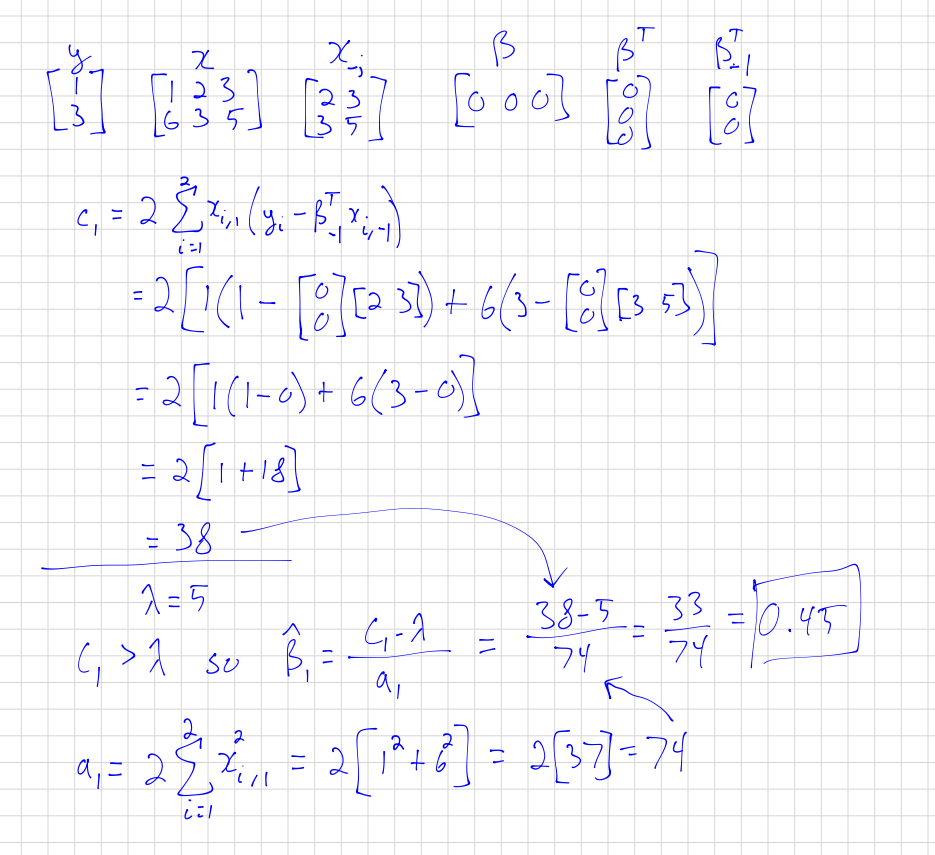

In [337]:
PATH = "/Users/Will/Documents/UW/DATA558/WEEK08/"
Image(filename = PATH + "check_work.png", width=800)

Looks like the math checks out (at least for this example)! I think the issue was with how the slides specified a dxn matrix, but I've been trying to stay in my nxd mindset and I likely made transpositional mistakes that were surprisingly hard to debug. I shoulda just written it out to begin with.

**Instructions**  
Consider the **Hitters** dataset. Standardize the data and center the outputs.  For any categorical variables, you should first convert them to indicator variables and then perform the standardization.

In [578]:
# Load the data
hitters = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv', sep=',', header=0)
hitters = hitters.dropna()

# Create x matrix with the predictors and y vector with the response
x = hitters.drop('Salary', axis=1)
x = pd.get_dummies(x, drop_first=True)
y = hitters.Salary

# Divide the data into training and test sets. By default, 25% goes into the test set.
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

# Standardize data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

**Instructions**  
Write a function _computeobj_ that computes and returns $F(\beta)$ for any $\beta$.

In [575]:
# the least elegant way that I should have done from the start
def computeobj(x, y, lamb, beta):
    n,d = x.shape
    f_inner = []
    g_inner = []
    for i in range(n):
        # empirical risk
        f_i = (y[i]-beta.T.dot(x[i].T))**2
        f_inner.append(f_i)
    for j in range(d):
        # shrinkage
        g_j = abs(beta[j])
        g_inner.append(g_j)
    f = 1/n*sum(f_inner)
    g = lamb*sum(g_inner)
    obj = f + g
    return obj

In [576]:
# testing to ensure functionality
x = np.array([[1,2,3],[6,3,5]])
n,d = x.shape
y = np.array([1,3]).reshape(2,1)
j = 0
beta = np.zeros([d,1])
lamb = 5

In [577]:
computeobj(x, y, lamb, beta)

array([5.])

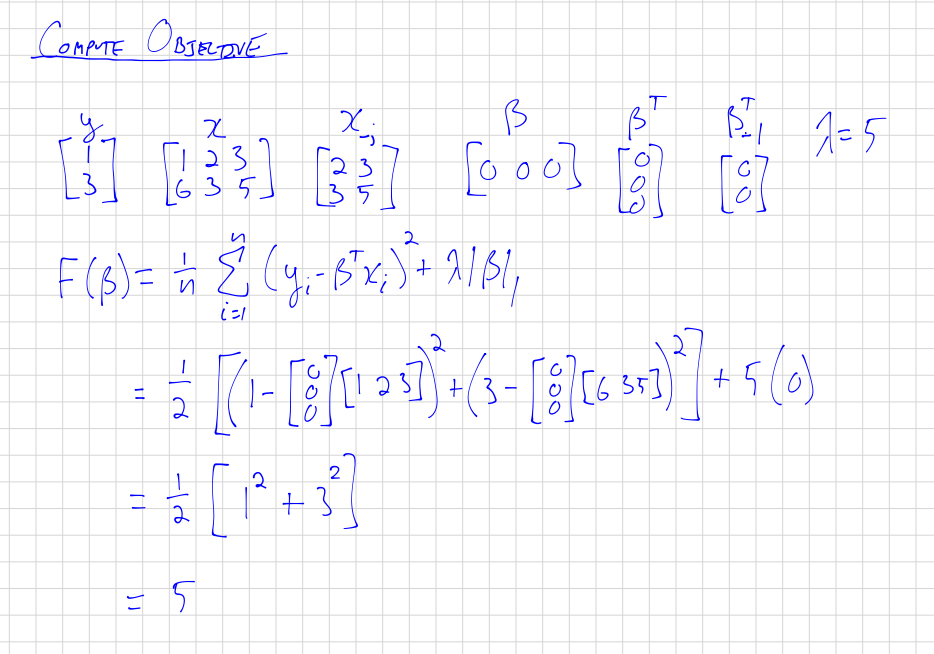

In [506]:
Image(filename = PATH + "check_work02.png", width=800)

**Comments**  
Again, lots of time wasted here because I had the square outside the parenthesis of the sum.  This led great frustration down below when I didn't catch this. Also, more debugging with trying to take the index with n instead of d for the sum of the absolute value of beta... oy!

**Instructions**  
Write a function _cycliccoorddescent_ that implements the _cyclic coordinate descent_ algorithm.  The cyclic coordinate descent algorithm proceeds sequentially.  At each iteration, the algorithm increments the index $j_t$ of the coordinate to minimize over.  Then the algorithm performs partial minimization with respect to the coordinate $\beta_{jt}$ corresponding to that index.  After updating the coordinate $\beta_{jt}$, the algorithm proceeds to the next iteratin.  The function takes as input the inital point and the maximum number of iterations.  The stopping criterion is the maximum number of iterations.

In [466]:
def cycliccoorddescent(x, y, lamb, coord = 0, max_iter = 1000):
    n,d = x.shape
    beta = np.zeros([d,1])
    betas = []
    objs = []
    t = 0
    while t < max_iter:
        # set coord to handle multiple cycles
        coord = int(t-(d*np.floor(t/d)))
        
        # calc new beta with bhat replacing the specified coord
        bhat = compute_bhat_Rd(x, y, lamb, beta, coord)
        beta[coord] = bhat
        betas.append(beta)
        
        # calc objective value
        obj = computeobj(x, y, lamb, beta)
        objs.append(obj)
        
        # iterate
        t += 1
    return np.array([betas, objs])

**Instructions**  
Write a function _pickcoord_ that samples uniformly from the set {$1,...d$}.

In [494]:
def pickcoord(x):
    d = x.shape[1]
    coord = np.random.randint(0,d)
    return coord

**Instructions**  
Write a function _randcoorddescent_ that implements the randomized coordinate descent algorithm. The randomized coordinate descent algorithm proceeds as follows. At each iteration, the algorithm samples the index $j_t$ of the coordinate to minimize over. Then the algorithm performs partial minimization with respect to the coordinate $\beta_{jt}$ corresponding to that index. After updating the coordinate $\beta_{jt}$, the algorithm proceeds to the next iteration. The function takes as input the initial point and the maximum number of iterations. The stopping criterion is the maximum number of iterations.


In [495]:
def randcoorddescent(x, y, lamb, max_iter = 1000):
    n,d = x.shape
    beta = np.zeros([d,1])
    betas = []
    objs = []
    t = 0
    while t < max_iter:
        # set coord to be randomly selected
        coord = pickcoord(x)
        
        # calc new beta with bhat replacing the specified coord
        bhat = compute_bhat_Rd(x, y, lamb, beta, coord)
        beta[coord] = bhat
        betas.append(beta)
        
        # calc objective value
        obj = computeobj(x, y, lamb, beta)
        objs.append(obj)
        
        # iterate
        t += 1
    return np.array([betas, objs])

**Instructions**  
Set the maximum number of iterations to 1000. In the remainder, the iteration counter iter refers here to $t/d$, that is the effective number of passes over all coordinates. Run cross-validation on the training set of the Hitters dataset using scikit-learn to find the optimal value of $\lambda$. Run _cycliccoorddescent_ and _randcoorddescent_ on the training set of the Hitters dataset for that value of $\lambda$ found by cross-validation. Plot the curves of the objective values $F(\beta_t)$ for both algorithms versus the iteration counter iter (use different colors). What do you observe?

In [496]:
lr_cv = sklearn.linear_model.LassoCV(fit_intercept=False, tol=10e-8, max_iter=1000, cv = 5)
lr_cv.fit(x_train, y_train)
optimal_lambda = lr_cv.alpha_

In [583]:
optimal_lambda

30.67748176923772

In [579]:
# convert data to format my functions take
y_train = np.array(y_train).reshape(len(y_train),1)

In [580]:
betas_cyc, objs_cyc = cycliccoorddescent(x_train, y_train, optimal_lambda)

In [581]:
betas_rand, objs_rand = randcoorddescent(x_train, y_train, optimal_lambda)

In [500]:
def objective_plot(objs_cyc, objs_rand):
    num_points_cyc = objs_cyc.shape[0]
    num_points_rand = objs_rand.shape[0]
    fig, ax = plt.subplots()
    ax.plot(range(1, num_points_cyc + 1), objs_cyc,
    label='cyclic coordinate descent')
    ax.plot(range(1, num_points_rand + 1), objs_rand, c='red',
    label='random coordinate descent')
    plt.xlabel('Iteration')
    plt.ylabel('Objective value')
    plt.title('Objective value vs. iteration')
    ax.legend(loc='upper right')
    plt.show()

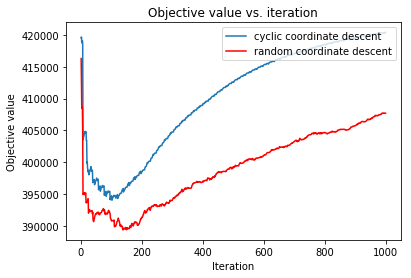

In [582]:
objective_plot(objs_cyc, objs_rand)

**Comments**  
Welp, it's better than the first several versions, but it still ain't right. It has steps... and they go down and to the right...just not forever. I believe that once fixed, the expected result will be cyclic consistently getting smaller, but slower than random, which will look more jagged in its descent.
  
I've debugged many of the above functions multiple times--each with its own unique weird graph. I'm sure I can get to the bottom of this, but I don't have the time.

**Instructions**  
Denote by $\beta_T$ the final iterates of your coordinate descent algorithms for that value of $\lambda$. Compute $\beta^*$ found by scikit-learn for that value of $\lambda$. Plot the curves of the fraction of correct non-zero coefficients (with respect to $\beta^*$) for both algorithms versus the iteration counter **iter** (use different colors). What do you observe? Plot the curves of the fraction of correct zero coefficients for both algorithms (with respect to $\beta^*$) versus the iteration counter **iter** (use different colors). What do you observe?


**Comments**  
I'm at about 17hrs with the reading and this is the progress I've made (heavy work week and last week + weekend was 100% midterm-focus; that plus I must be extraodinarily slow with python (R ftw)). I _think_ I'm out of hw extensions so I'll have to leave it at this. It's possible that I have one remaining, but I'm not sure since I can't recall if we got a free extension for hw4.  I'll try an upload tomorrow and, if successful, will continue on.  I _think/hope_ the rest of the assignment should take a fraction of the time since it's just applying what was created above (and debugging...).